# **Group 1 Final Project - Spotify Predictions**

### **Group 1: Arnav Sareen, Bita Ghaffari, Carter Leonard, Rushil Jadia, Sindhu Gadiraju, Sohol Maghzian**

### **Introduction**

Here is the intro to the project, giving information on the problem and how we are trying to solve it. We will go in detail on what the data is, what we will do with it, and other necessary introduction information.

### **Data Collection - Arnav Sareen**

In [ ]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.exceptions import SpotifyException
import http.client
import deezer
from dotenv import load_dotenv
from mutagen.mp3 import MP3
import io
import os.path
import tempfile
import requests
import os
import random
from pydub import AudioSegment
from pydub.utils import which
import boto3
from botocore.client import Config

In [ ]:
# Cell to get a dependency for one of my packages loaded up in the right manner
os.environ["PATH"] += os.pathsep + r"C:\ffmpeg\ffmpeg-7.1.1-essentials_build\bin"
AudioSegment.converter = which("ffmpeg")
AudioSegment.ffprobe = which("ffprobe")

In [ ]:
# Load in the dataframes
high_popularity_df: pd.DataFrame = pd.read_csv('./data/high_popularity_spotify_data.csv')
low_popularity_df: pd.DataFrame = pd.read_csv('./data/low_popularity_spotify_data.csv')

In [ ]:
print(f'There are {high_popularity_df.shape[0]:,} rows in the high popularity dataset')
high_popularity_df.head(20)

In [ ]:
print(f'There are {low_popularity_df.shape[0]:,} rows in the low popularity dataset')
low_popularity_df.head(20)

In [ ]:
df: pd.DataFrame = pd.concat([low_popularity_df, high_popularity_df], axis = 0)
print(f'There are {df.shape[0]:,} rows in the combined dataset')
df.head(20)

In [ ]:
print(df['playlist_subgenre'].value_counts())

In [ ]:
# Load our environment variables for the spotify and file uploading
load_dotenv()

In [ ]:
def authenticate_spotify() -> spotipy.Spotify:
    """Authenticate the spotify API with the necessary credentials.
    You can create an account and access the necessary credentials at https://developer.spotify.com/dashboard

    Returns:
        spotipy.Spotify: spotipy object to make calls to
    """
    CLIENT_ID: str = os.getenv('SPOTIFY_CLIENT_ID')
    CLIENT_SECRET:str = os.getenv('SPOTIFY_CLIENT_SECRET')
    auth_manager: SpotifyClientCredentials = SpotifyClientCredentials(client_id = CLIENT_ID, client_secret = CLIENT_SECRET)
    sp = spotipy.Spotify(auth_manager = auth_manager)

    return sp

In [ ]:
def get_new_song_data(sp: spotipy.Spotify, song_name: str, artist_name: str) -> dict[str, str|int]:
    """retrieve song information from the spotify API and return the relevant information

    Args:
        sp (spotipy.Spotify): spotipy object
        song_name (str): name of the track to retrieve data for
        artist_name (str): _description_

    Raises:
        ValueError: When no matching songs are found
        ConnectionError: When rate limit is exceeded
        Exception: For any other errors

     Returns:
        dict[str, str|int]: Dictionary containing track information
    """
    print(f'Retrieving data for {song_name} by {artist_name}')
    query:str = f'track:{song_name} artist:{artist_name}'
    try:
        song_data: dict = sp.search(q = query, type = 'track', limit = 1)

        # Ensure songs were returned
        if not song_data['tracks']['items']:
                raise ValueError(f"No songs found for {song_name} by {artist_name}")

        track_data: dict = song_data['tracks']['items'][0]
        track_href: str = track_data['href']
        track_name: str = track_data['name']
        uri: str = track_data['uri']
        release_date: str = track_data['album']['release_date']
        track_album_name: str = track_data['album']['name']
        track_album_id: int = track_data['album']['id']
        duration: int = track_data['duration_ms']
        playlist_id: int = track_data['album']['id']
        track_id: int = track_data['id']
        popularity: int = track_data['popularity']
        

        return {
            'track_href': track_href,
            'track_artist': artist_name,
            'track_name': track_name,
            'uri': uri,
            'track_album_release_date': release_date,
            'track_album_name': track_album_name,
            'duration_ms': duration,
            'playlist_id': playlist_id,
            'track_id': track_id,
            'id': track_id,
            'track_popularity': popularity
        }
    except SpotifyException as e:
        if e.http_status == 429:
            raise ConnectionError('The rate limited has been exceeded. Please try again in a few minutes.')
    except Exception as e:
        if isinstance(e, ValueError):
             raise
        raise Exception(f'An error occured: {e}')


In [ ]:
# We need to get the genre of the playlist in an alternative way, so I am just getting the artist's genres in general via Deezer
def get_genres(artist_name: str, album_name: str) -> dict[str, str]:
    """retrieve the genre of the song (or the album in which the song is in) from the Deezer API

    Args:
        artist_name (str): name of the artist of the inputted track
        album_name (str): name of the album of the inputted track

    Raises:
        ValueError: if no album is found that that artist and album name

    Returns:
        dict[str, str]: the name of the genre, assigned to 'genre' as a key
    """
    with deezer.Client() as client:
        query: str = f'artist:"{artist_name}" album:"{album_name}"'
        album: deezer.Album = client.search_albums(query = query)

        if not len(album):
            raise ValueError(f"No albums for {album_name} by {artist_name} from the Deezer API")
        
        # Extract the album from the paginated list
        artist_album: dict = album[0].as_dict()

        # Get the genre from the dict
        genre_id: int = artist_album['genre_id']

        # Now we need to get the genre itself
        genre_dict: dict = client.get_genre(genre_id).as_dict()

        genre: dict[str, str] = {
            'playlist_genre': genre_dict['name']
        }

        return genre

In [ ]:
# In order to extract audio features, we need to get an audio sample from the Deezer API which we can then upload the ReccoBeats API
def get_audio_sample(track_name: str, artist_name: str, album_name: str) -> dict[str, str]:
    """retrieves an audio sample from the Deezer api

    Args:
        track_name (str): name of the inputted track
        artist_name (str): artist of the inputted track
        album_name (str): album name of the inputted track

    Raises:
        ValueError: if no track is found by that artist in that album

    Returns:
        dict[str, str]: the url of the song sample, assigned to 'song_url'
    """
    with deezer.Client() as client:
        track: deezer.Track = client.search(query = track_name, artist = artist_name, album = album_name)
        
        if not len(track):
            raise ValueError(f"No track found for {track_name} by {artist_name} from the Deezer API")
        
        song_url: str = track[0].preview
        song_url_dict: dict[str, str] = {
            'song_url': song_url
        }

        return song_url_dict

In [ ]:
def save_song_to_cache(song_url: str, song_id: int) -> str:
    """save a song to the diskcache for later uploading

    Args:
        cache (dc.Cache): diskcache object with initialized cache directory
        song_url (str): deezer song preview url
        song_id (int): spotify song id

    Returns:
        str: cache key
    """
    song_data: requests.Response = requests.get(song_url, stream = True)

    content_type = song_data.headers.get("Content-Type", "")
    if "audio/mpeg" not in content_type:
        raise ValueError(f"Invalid content type: {content_type}")

    try:
        mp3 = MP3(io.BytesIO(song_data.content))
        print(f"Duration: {mp3.info.length:.2f} sec")
    except Exception as e:
        raise ValueError(f"Corrupted MP3: {e}")

    # Save the song data to a temporary folder cache
    # Create a temporary directory if it doesn't exist
    
    temp_dir = tempfile.gettempdir()
    cache_key = f'{song_id}.mp3'
    temp_file_path = os.path.join(temp_dir, cache_key)
    
    # Save to temporary file
    with open(temp_file_path, 'wb') as f:
        f.write(song_data.content)
    
    print(f"Saved {len(song_data.content)} bytes to temp directory: {temp_file_path}")

    return temp_file_path

In [ ]:
def reencode_mp3(song_id: str) -> io.BytesIO:
    """reencode a mp3 file for uploading

    Args:
        song_id (str): song_id / file_name located within the temporary directory 

    Returns:
        io.BytesIO: bytes for the mp3 file
    """
    temp_dir = tempfile.gettempdir()
    input_path = os.path.join(temp_dir, f'{song_id}.mp3')
    audio = AudioSegment.from_file(input_path, format="mp3")

    buffer = io.BytesIO()
    audio.export(buffer, format="mp3", bitrate="192k")

    buffer.name = os.path.basename(input_path) 
    buffer.seek(0)
    
    return buffer

In [ ]:
def extract_audio_features(song_id: str):
    """upload the audio sample to the ReccoBeats API and get the audio features

    Args:
        song_id (str): file-name / song_id located within the temporary directory

    Returns:
        response (dict[str, float]): audio features
    """
    mp3_buffer = reencode_mp3(song_id)

    url: str = "https://api.reccobeats.com/v1/analysis/audio-features"

    files: dict(str, tuple(str)) = {
        'audioFile': (f'{song_id}.mp3', mp3_buffer, 'audio/mpeg')
    }

    headers: dict(str, str) = {
        'Accept': 'application/json'
    }

    response: requests.Response = requests.post(url, headers=headers, files=files)

    try:
        return response.json()
    except Exception:
        return response.text

In [ ]:
def clean_up_files(song_id: str) -> bool:
    """delete files within the temporary directory

    Args:
        song_id (str): file-name / song id of the file within the temporary directory

    Returns:
        bool: _description_
    """
    try:
        temp_dir = tempfile.gettempdir()
        input_path = os.path.join(temp_dir, f'{song_id}.mp3')
        if os.path.exists(input_path):
            os.remove(input_path)
            print(f'{song_id}.mp3 deleted successfully')
            return True
        else:
            print(f'File {input_path} not found')
    except PermissionError:
        print(f'Permission denied, was unable to delete: {input_path}')
    
    return False

In [ ]:
def get_new_song(song_name: str, artist_name: str):
    sp: spotipy.Spotify = authenticate_spotify()
    print(f'Getting the song data for {song_name} by {artist_name}...')
    song_data: dict[str, str|int] = get_new_song_data(sp, song_name, artist_name)
    album: str = song_data['track_album_name']
    song_id: int = song_data['track_id']

    # Get the genre for the desired song
    print(f'Getting the genre for {song_name} by {artist_name}...')
    genre: dict[str, str] = get_genres(artist_name, album)

    # Extract the audio sample for the desired song
    print(f'Getting the song URL for {song_name} by {artist_name}...')
    song_url: dict[str, str] = get_audio_sample(song_name, artist_name, album)

    # Get the song audio data
    print(f'Retrieving {song_name} by {artist_name} and saving it to a temporary directory')
    song_audio_path: str = save_song_to_cache(song_url['song_url'], song_id)
    features: dict[str, float] = extract_audio_features(song_id)

    # Ensure features has the right keys
    if not set(features.keys()).issubset(set(['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'])):
        raise ValueError('All of the features were not returned from the ReccoBeats API')

    # Clean up the files so they don't pile up
    clean_up_files(song_id)

    # Conglomerate everything into a single dictionary
    full_dict: dict[str, str|float] = {}
    full_dict.update(song_data)
    full_dict.update(genre)
    full_dict.update(song_url)
    full_dict.update(features)
    
    # Add data that we couldn't get from the API
    full_dict['time_signature'] = 4.0
    full_dict['playlist_name'] = 'custom'
    full_dict['playlist_subgenre'] = 'custom'
    full_dict['mode'] = random.randint(0,1)
    full_dict['key'] = random.randint(0,11)
    full_dict['type'] = 'audio_features'
    full_dict['analysis_url'] = "https://api.reccobeats.com/v1/analysis/audio-features"
    full_dict['playlist_id'] = 'custom'

    print(full_dict)
    return full_dict

In [ ]:
get_new_song('Am I Dreaming', 'Metro Boomin')

In [ ]:
df.loc[len(df)] = get_new_song('Bleeding Me Dry', 'Alicia Creti')

In [ ]:
df.loc[len(df)] = get_new_song('So Good', 'Weston Estate')

In [ ]:
df.loc[len(df)] = get_new_song('Soldi', 'Mahmood')

In [ ]:
df.loc[len(df)] = get_new_song('Walls', 'Ryan Woods')

In [ ]:
df.tail(5)

In [ ]:
# Set up the uploading to the cloud
# You can access our updated CSVs by going to http://pub-bbe55fdef5ad4012b706401d4105e027.r2.dev/data.csv
def save_data_to_cloud() -> None:
    ACCESS_KEY = os.getenv('CLOUDFLARE_ACCESS_KEY_ID')
    SECRET_KEY = os.getenv('CLUOUDFLARE_SECRET_ACCESS_KEY')
    BUCKET_NAME = 'spotify-dataset'
    endpoint_url = 'https://61c8452455a55a170873037facd5bcca.r2.cloudflarestorage.com'

    s3 = boto3.client(
        's3',
        aws_access_key_id = ACCESS_KEY,
        aws_secret_access_key = SECRET_KEY,
        endpoint_url = endpoint_url,
        config = Config(signature_version = 's3v4'),
        region_name = 'auto'
    )

    df.to_csv('data.csv')
    s3.upload_file(
        Filename = './data.csv', 
        Bucket = BUCKET_NAME, 
        Key = 'data.csv'
    )

    print(f'The data has successfully been uploaded to the cloud!')

In [ ]:
save_data_to_cloud()

### **Clustering - Carter Leonard & Rushil Jadia**

Before we begin, we will import all necessary libraries and read the CSV file:

In [69]:
! pip install pandas numpy matplotlib scikit-learn statsmodels seaborn

7839.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [70]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import *

### **Clustering Model 1: Hierarchical Clustering**

In [103]:
low_df = pd.read_csv("data/low_popularity_spotify_data.csv")
high_df = pd.read_csv("data/high_popularity_spotify_data.csv")

### **Hierarchical Clustering: Pre-Processing**

Here is the head of the lower dataframe:

In [104]:
low_df.head()

,time_signature,track_popularity,speechiness,danceability,playlist_name,track_artist,duration_ms,energy,playlist_genre,playlist_subgenre,...,track_album_id,playlist_id,track_id,valence,key,tempo,loudness,acousticness,liveness,track_album_name
0,4.0,23,0.0393,0.636,Rock Classics,Creedence Clearwater Revival,138053.0,0.746,rock,classic,...,4A8gFwqd9jTtnsNwUu3OQx,37i9dQZF1DWXRqgorJj26U,5e6x5YRnMJIKvYpZxLqdpH,0.432,0.0,132.310,-3.785,0.0648,0.1730,The Long Road Home - The Ultimate John Fogerty...
1,4.0,53,0.0317,0.572,Rock Classics,Van Halen,241600.0,0.835,rock,classic,...,2c965LEDRNrXXCeBOAAwns,37i9dQZF1DWXRqgorJj26U,5FqYA8KfiwsQvyBI4IamnY,0.795,0.0,129.981,-6.219,0.1710,0.0702,The Collection
2,4.0,55,0.0454,0.591,Rock Classics,Stevie Nicks,329413.0,0.804,rock,classic,...,3S404OgKoVQSJ3xXrDVlp8,37i9dQZF1DWXRqgorJj26U,5LNiqEqpDc8TuqPy79kDBu,0.658,0.0,111.457,-7.299,0.3270,0.0818,Bella Donna (Deluxe Edition)
3,4.0,64,0.1010,0.443,Jazz Classics,"Ella Fitzgerald, Louis Armstrong",185160.0,0.104,jazz,classic,...,1y5KGkUKO0NG32MhIIagCA,37i9dQZF1DXbITWG1ZJKYt,78MI7mu1LV1k4IA2HzKmHe,0.394,0.0,76.474,-17.042,0.9130,0.1910,"Love, Ella"
4,4.0,62,0.0298,0.685,Jazz Classics,Galt MacDermot,205720.0,0.472,jazz,classic,...,6f4b9wVTkKAf096k4XG6x5,37i9dQZF1DXbITWG1ZJKYt,6MN6yRVriszuyAVlyF8ndB,0.475,9.0,80.487,-9.691,0.7850,0.2240,Shapes of Rhythm/Woman Is Sweeter


Here is the head of the higher dataframe:

In [106]:
high_df.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3,0.0304,...,0.0000,10FLjwfpbxLmW8c25Xyc2N,0,6,251668,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4,0.0358,...,0.0608,7aJuG4TFXa2hmE4z1yxc3n,1,2,210373,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4,0.0368,...,0.0000,0hBRqPYPXhr1RkTDG3n4Mk,1,1,166300,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4,0.0634,...,0.0000,4B4Elma4nNDUyl6D5PvQkj,0,0,157280,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4,0.2600,...,0.0000,2IYQwwgxgOIn7t3iF6ufFD,0,0,169917,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M


### **Hierarchical Clustering: Modeling**

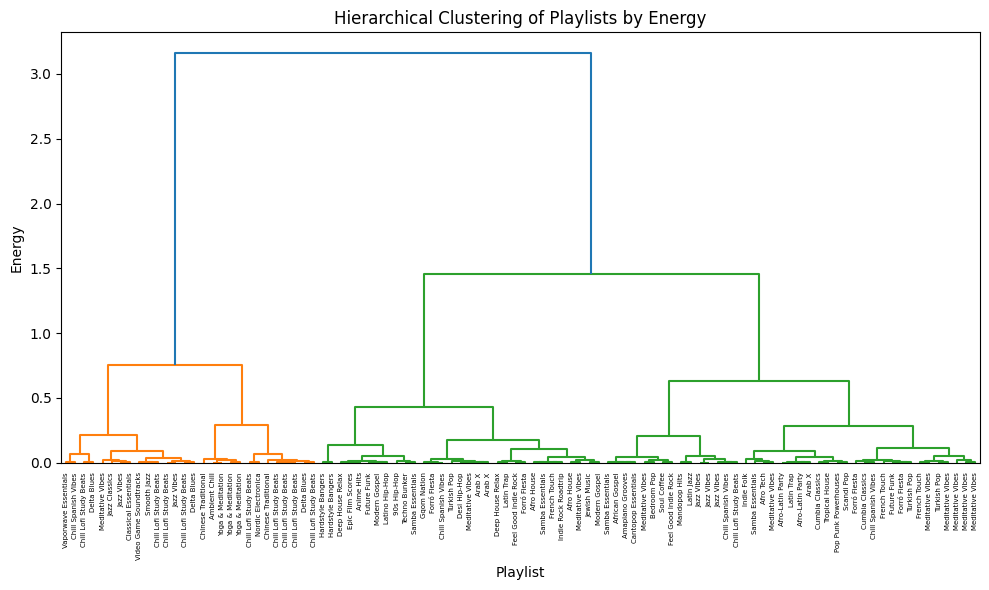

In [101]:
from scipy.cluster.hierarchy import dendrogram, linkage

df = pd.read_csv('data/low_popularity_spotify_data.csv')

df['energy'] = pd.to_numeric(df['energy'], errors = 'coerce')
df = df.dropna(subset=['energy'])

if len(df) > 100:
    df = df.sample(n=100, random_state=42).reset_index(drop=True)

energy_values = df[['energy']].values

linked = linkage(energy_values, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linked, 
           labels=df['playlist_name'].values,
           orientation='top',
           distance_sort='ascending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering of Playlists by Energy')
plt.xlabel('Playlist')
plt.ylabel('Energy')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### **Hierarchical Clustering: Evaluation**

This hierarchical clustering combines playlist names with the energy that the user wants in a playlist. The top 100 playlists in the low popularity chart were graphed out to match the desired energy to the playlist that matches. Preparing the data was simple enough due to only singling out the two columns within the CSV file and then making sure the cluster was properly matching the playlists to their energy, ensuring that if a user wants a specific playlist within a certain amount of energy, that the search would be narrowed down and simple for the user.

### **Clustering Model 2: K-Means Clustering**

Now that we are testing another model, we will need to redo the pre-processing:

### **K-Means Clustering: Pre-Processing**

In [107]:
low_data = pd.read_csv("data/low_popularity_spotify_data.csv")
high_data = pd.read_csv("data/high_popularity_spotify_data.csv")

In [74]:
df = pd.concat([high_data, low_data], ignore_index=True)

Now that we've combined the high and low dataframes, we are able to get a better representation of the data! We will move into deciding what factors will determine the accuracy of this recommender system.

In [75]:
features = ['energy', 'tempo', 'valence', 'danceability', 'track_artist','playlist_name', 'playlist_genre', 'playlist_subgenre']

We need to drop all nulls for this model and remove all unnecessary info from the dataframe.

In [76]:
df = df[features].dropna()

We will split the columns into different genres: Categorical and Numerical features:

In [77]:
numerical_features = ['energy', 'tempo', 'valence', 'danceability']
categorical_features = ['track_artist', 'playlist_name', 'playlist_genre', 'playlist_subgenre']

In [78]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

### **K-Means Clustering: Modeling**

Before we begin the clustering process, we will transform the data.

In [79]:
X = preprocessor.fit_transform(df)

In [80]:
df_cols = list(df.columns)

dummy_vars = []
for var in categorical_features:
    feature_list = set(df[var].to_list())
    dummy_vars.append(feature_list)

X_cols = list(df_cols + dummy_vars)

In [ ]:
X_cols

['energy',
 'tempo',
 'valence',
 'danceability',
 'track_artist',
 'playlist_name',
 'playlist_genre',
 'playlist_subgenre',
 {'Micro TDH',
  'Esbjörn Svensson Trio',
  'AUR',
  'MVCA, SCHWARZ',
  'Alberto Di Paulo',
  'Richard Elliot',
  'Smokey Bastard',
  'Meek Mill, Drake',
  'Chance Peña',
  'Epic North, Peter Roe',
  'Onedin',
  'Johnny Drille, Don Jazzy',
  'Arijit Singh, Aditi Singh Sharma',
  'Naira Marley, Zinoleesky',
  'Saint Motel',
  'Ben Crosland',
  'Raphah',
  'Yaelokre',
  'V',
  'Arvo Pärt, Mari Samuelsen, TrondheimSolistene',
  'Noflik, Pleij',
  'Xaxado Novo, Bruno Duarte',
  'Yng Lvcas, Peso Pluma',
  'Allen Stone',
  "Kungs, Cookin' On 3 Burners",
  'Natanael Cano, Uriel Gaxiola, Ganggy, Victor Mendivil',
  '_tag',
  'Red Velvet',
  'Grupo Fundo De Quintal',
  'Franz Liszt, Lise de la Salle',
  'Los Poboycitos',
  'Ludovico Einaudi, Daniel Hope, I Virtuosi Italiani',
  'Swedish House Mafia, John Martin',
  'VIIVI, Robin Packalen',
  'G:sson',
  'ODESZA, Zyra',
 

In [82]:
X.shape

(4830, 3628)

In [83]:
print(len(X_cols))

12


Now that we made necessary changes before actually beginning the clustering process, we should check what the ideal amount of clusters is to  make these predictions.

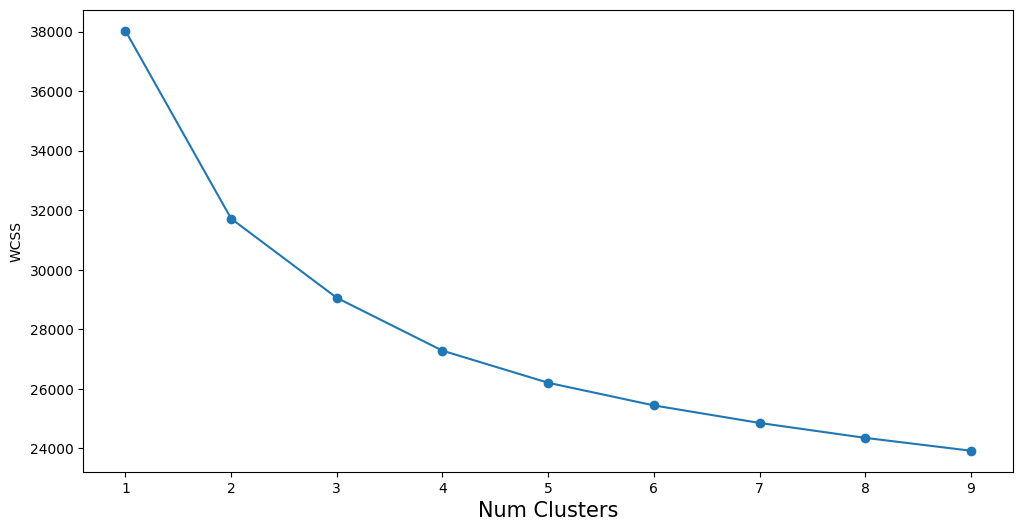

In [84]:
inertias = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(12,6))
plt.plot(range(1,10), inertias, marker ='o')
plt.xlabel('Num Clusters', fontsize = 15)
plt.ylabel('WCSS')
plt.show()

As expected, the lesser number of clusters, the higher chance of accuracy. Now we can actually begin, by using K-Means:

In [85]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
df['kmeans_cluster'] = kmeans_labels
print("KMeans Silhouette Score:", silhouette_score(X, kmeans_labels))

KMeans Silhouette Score: 0.18093874382786207


Looks like it worked, but the Silhouette score is very low. We may need to reduce the sample size, so we will use PCA for this next section. Using PCA, we will do dimensionality reduction, and visualize the silhouettes scores for each PC.

In [87]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(X)
loadings = pca.components_
loadings

array([[ 0.55899483,  0.17875636,  0.58766156, ..., -0.00179783,
         0.00186416, -0.03127674],
       [ 0.14789075,  0.92575342, -0.14487857, ...,  0.00114007,
         0.0012608 ,  0.00373005],
       [ 0.67363694, -0.32575888,  0.0062428 , ...,  0.00177847,
         0.00142304,  0.00294286]], shape=(3, 3628))

In [88]:
pca_df = pd.DataFrame(
    reduced_data, 
    columns=['PC1', 'PC2', 'PC3']
)
pca_df['Cluster'] = kmeans_labels  # Append cluster labels for plotting

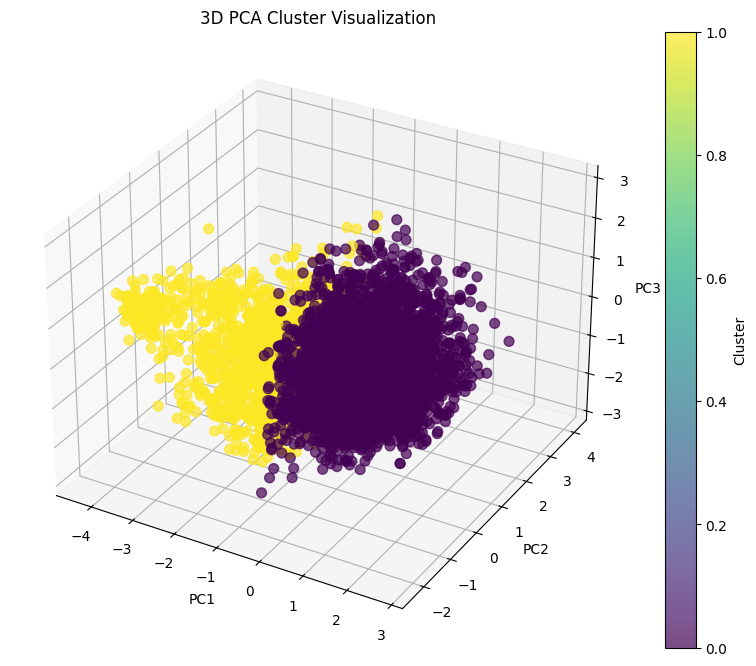

In [89]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    pca_df['PC1'], 
    pca_df['PC2'], 
    pca_df['PC3'], 
    c=pca_df['Cluster'], 
    cmap='viridis', 
    s=50,
    alpha=0.7
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Cluster Visualization')
plt.colorbar(scatter, label='Cluster')
plt.show()


Here we have a 3-D graph visualizing the PCA clusters, and how much the silhouette score would be around. The color bar on the right gives us a better idea of the silhouette scores for each cluster, and it seems that there is a higher score than before, but there is still a low score overall.

Now we will run K-Means again to see if we have a more accurate representation:

In [92]:
# Use the reduced data for clustering
kmeans_pca = KMeans(n_clusters=2, random_state=42)
kmeans_labels_pca = kmeans_pca.fit_predict(reduced_data)

# Evaluate new silhouette score
from sklearn.metrics import silhouette_score
print("Silhouette Score (after PCA):", silhouette_score(reduced_data, kmeans_labels_pca))

Silhouette Score (after PCA): 0.36888607083708297


It seems as if the silhouette score did increase, which is a good sign. However, it doesn't seem accurate enough to recommend songs to a user based on these features. We will try to reduce outliers by computing Z-Scores across PCA components and keeping rows where all PC's have z > 3. We will then filter the reduced and original data and run the K-Means algorithm againt to see if there is an increase in the silhouette score.

Z-Score & Reducing Outliers

In [93]:
from scipy.stats import zscore

# Compute z-scores across PCA components
z_scores = np.abs(zscore(reduced_data))
outlier_mask = (z_scores < 3).all(axis=1)  # Keep rows where all PCs have z < 3

# Filter the reduced and original data
reduced_data_filtered = reduced_data[outlier_mask]
X_filtered = X[outlier_mask]

In [99]:
kmeans_filtered = KMeans(n_clusters=2, random_state=42)
labels_filtered = kmeans_filtered.fit_predict(reduced_data_filtered)

print("Silhouette Score (after outlier removal):", silhouette_score(reduced_data_filtered, labels_filtered))

Silhouette Score (after outlier removal): 0.3688377206353001


### **K-Means Clustering: Evaluation**

After these tests and changes made to the dataframe to fit our goal, it seems as if K-Means is not the best clustering approach to meet our goals and help solve our problem. However, we are able to gain insight on what factors should be considered and how much data we should test to create a recommender system. For example, the subgenres column has many unique values, and may even categorize a subgenre as an artist's name or make a similar issue. Those factors need to be avoided when it comes to clustering and perhaps a better modeling approach should be taken to create this recommender system.